<a href="https://colab.research.google.com/github/kaitlynrv/classification-predictions/blob/main/Project2_Forecasting_Kaitlyn_Vickers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Kaitlyn Vickers

**Date:** 10/24/2023

**Assignmemt:** Project 2 Forecasting

##Import Libraries and Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [ ]:
df = pd.read_csv('/content/BaggageComplaints.csv')
df

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581
...,...,...,...,...,...,...,...,...
247,United,08/2010,8,2010,14099,30637,344,4263211
248,United,09/2010,9,2010,9435,28072,161,3679517
249,United,10/2010,10,2010,9565,29144,140,3952549
250,United,11/2010,11,2010,8597,27318,104,3573268


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    252 non-null    object
 1   Date       252 non-null    object
 2   Month      252 non-null    int64 
 3   Year       252 non-null    int64 
 4   Baggage    252 non-null    int64 
 5   Scheduled  252 non-null    int64 
 6   Cancelled  252 non-null    int64 
 7   Enplaned   252 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.9+ KB


In [ ]:
df.head()

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581


## Format Columns

In [ ]:
#change to date time
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y').dt.strftime('%b-%y')
df.set_index('Date', inplace=True)

In [ ]:
#drop columns
df = df.drop(['Month', 'Year'], axis=1)


In [ ]:
airlines= df['Airline'].value_counts()
airlines

American Eagle    84
Hawaiian          84
United            84
Name: Airline, dtype: int64

In [ ]:
#drop Hawaiian
df = df[df['Airline'] != 'Hawaiian']
df.head()

,Airline,Baggage,Scheduled,Cancelled,Enplaned
Date,,,,,
Jan-04,American Eagle,12502,38276,2481,992360
Feb-04,American Eagle,8977,35762,886,1060618
Mar-04,American Eagle,10289,39445,1346,1227469
Apr-04,American Eagle,8095,38982,755,1234451
May-04,American Eagle,10618,40422,2206,1267581


In [ ]:
airlines= df['Airline'].value_counts()
airlines

American Eagle    84
United            84
Name: Airline, dtype: int64

In [ ]:
#Create American Eagle df and United df
american_eagle_df = df[df['Airline'] == 'American Eagle'].reset_index()
american_eagle_df['Date'] = pd.to_datetime(american_eagle_df['Date'], format='%b-%y')
american_eagle_df.head()

,Date,Airline,Baggage,Scheduled,Cancelled,Enplaned
0,2004-01-01,American Eagle,12502,38276,2481,992360
1,2004-02-01,American Eagle,8977,35762,886,1060618
2,2004-03-01,American Eagle,10289,39445,1346,1227469
3,2004-04-01,American Eagle,8095,38982,755,1234451
4,2004-05-01,American Eagle,10618,40422,2206,1267581


In [ ]:
united_df = df[df['Airline'] == 'United'].reset_index()
united_df['Date'] = pd.to_datetime(united_df['Date'], format='%b-%y')
united_df.head()

,Date,Airline,Baggage,Scheduled,Cancelled,Enplaned
0,2004-01-01,United,25015,45809,1017,4434315
1,2004-02-01,United,16660,42675,312,4458657
2,2004-03-01,United,19318,46512,321,5302929
3,2004-04-01,United,15638,45309,162,5288871
4,2004-05-01,United,19302,46630,652,5408451


#ARIMA Model for United and Cancelled

##Plot the Time Series

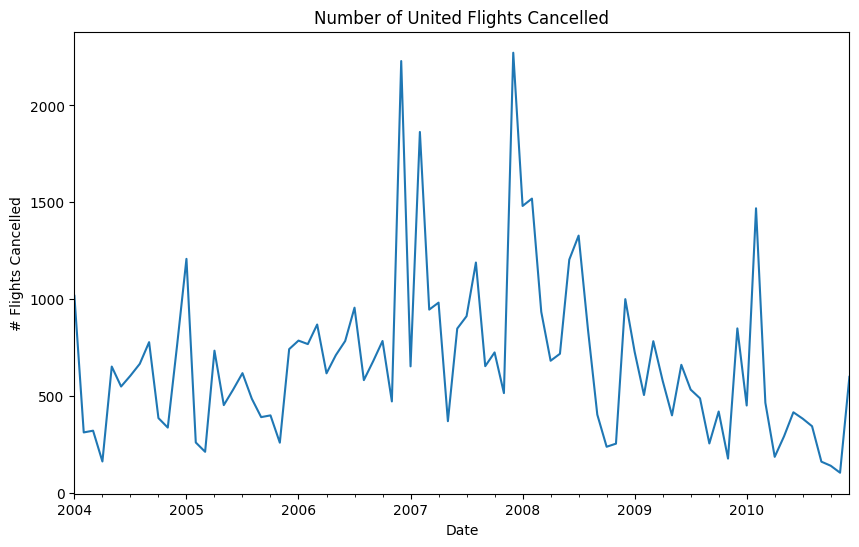

In [ ]:
# Create a monthly index for the series
united_cancelled_ts = pd.Series(united_df['Cancelled'].values, index=united_df['Date'])

united_cancelled_ts.index.freq = 'MS'


#Plot the series
plt.figure(figsize=(10, 6))
united_cancelled_ts.plot()
plt.title("Number of United Flights Cancelled")
plt.xlabel("Date")
plt.ylabel("# Flights Cancelled")
plt.show()

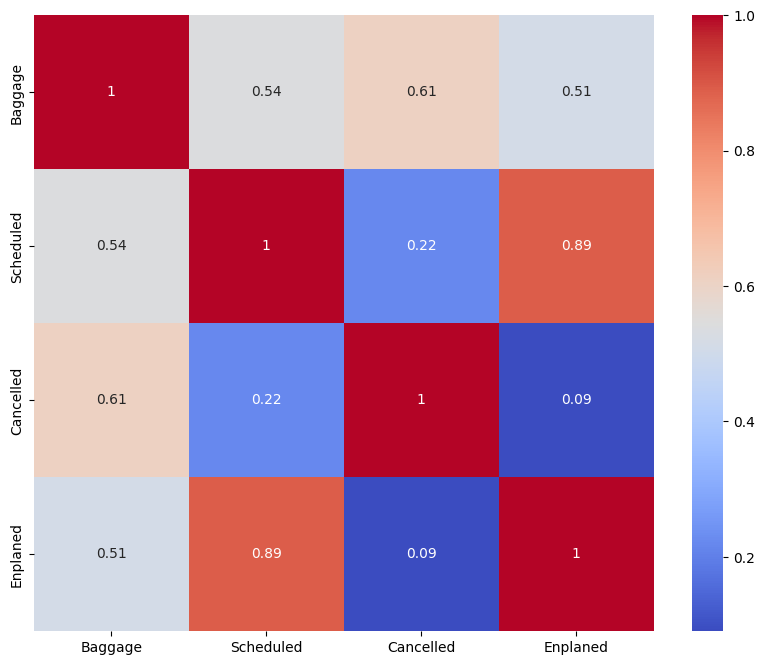

In [ ]:
#Produce Heat Map
united_dat_sub = united_df.drop(columns=['Airline', 'Date'])


# Compute correlations
cormat = united_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

In [ ]:
#Check for autocorrelation
United_Cancelled= united_df[['Cancelled']]

sm.stats.acorr_ljungbox(United_Cancelled, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,37.135304,0.000054


Since the p-value is 0.000054, we conclude there is not white noise in the number of flights cancelled per month for the United

##Plot ACF and PACF

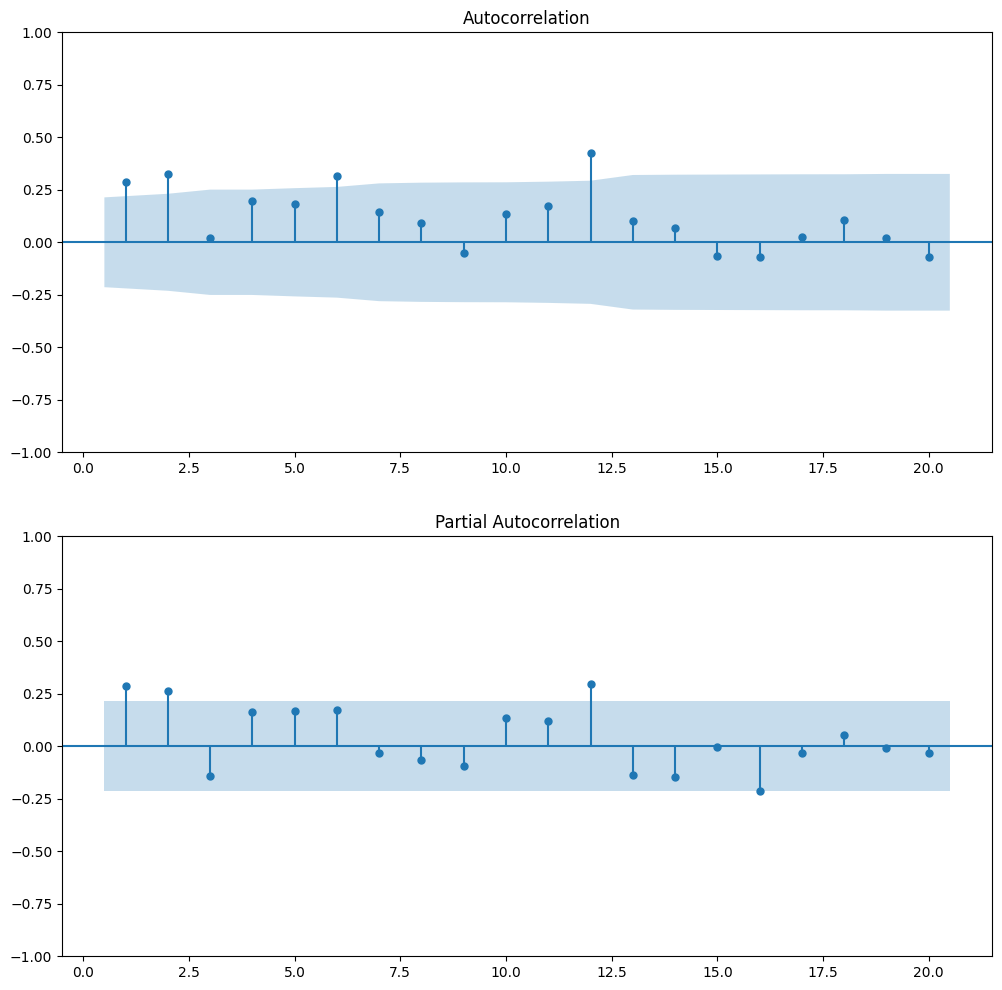

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(united_cancelled_ts, ax=ax1, zero=False)
plot_pacf(united_cancelled_ts, ax=ax2, zero=False)
plt.show()

##ARIMA Differencing

ACF spike at about 12 and no trend in ACF or PACF so choose S=12 and D=1

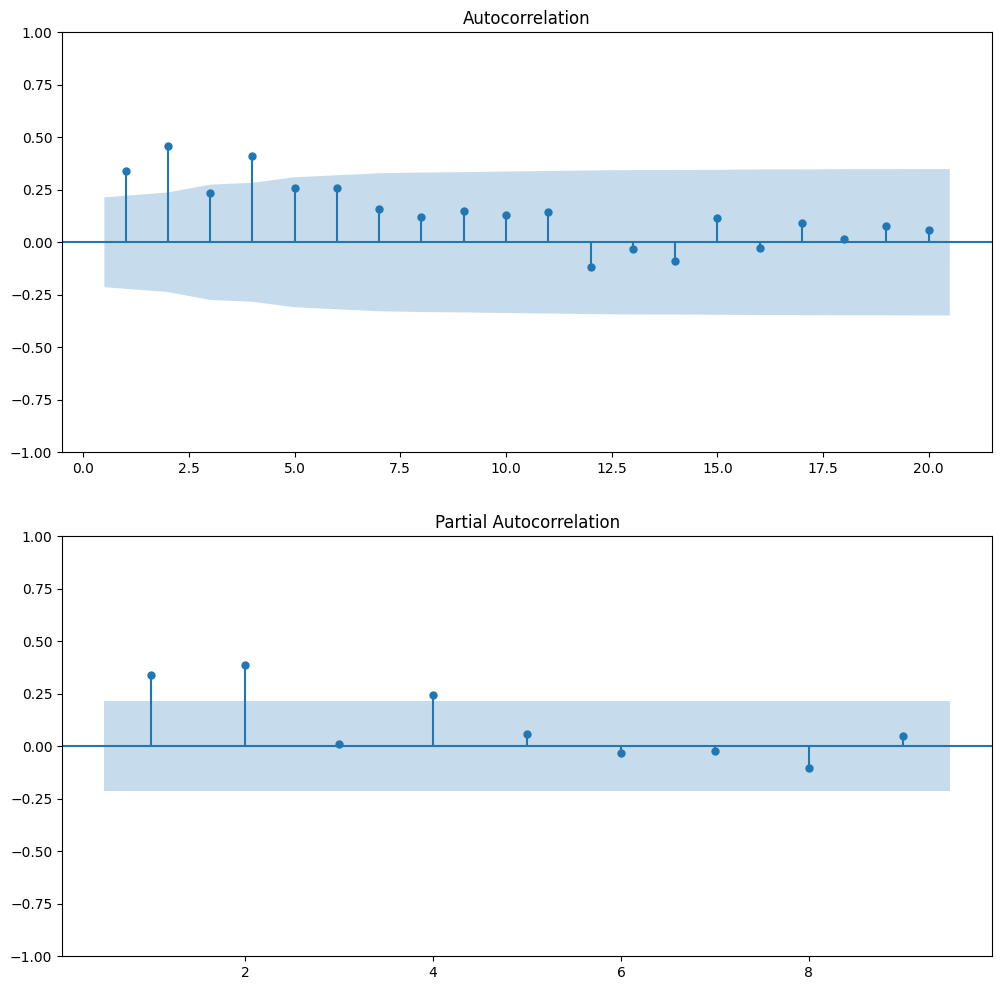

In [ ]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_cancelled_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(4, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -525.618
Date:                            Tue, 24 Oct 2023   AIC                           1063.237
Time:                                    21:27:36   BIC                           1076.897
Sample:                                01-01-2004   HQIC                          1068.675
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1567      0.100      1.574      0.115      -0.038       0.352
ar.L2          0.3243      0.094   

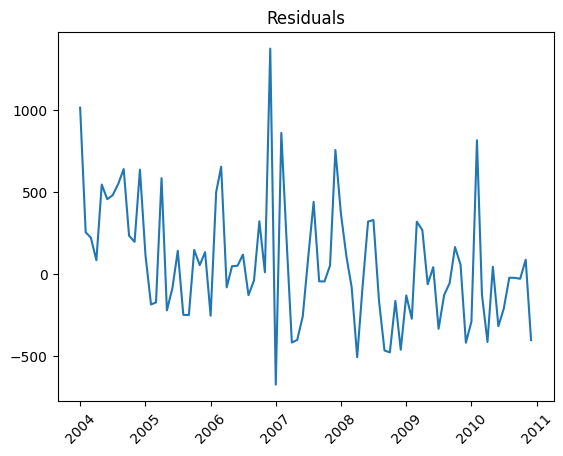

In [ ]:
#Best model for Cancelled Flights for United is ARIMA(4,0,0)x(0,1,1)[12]
fit_AR1 = ARIMA(united_cancelled_ts, order=(4,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


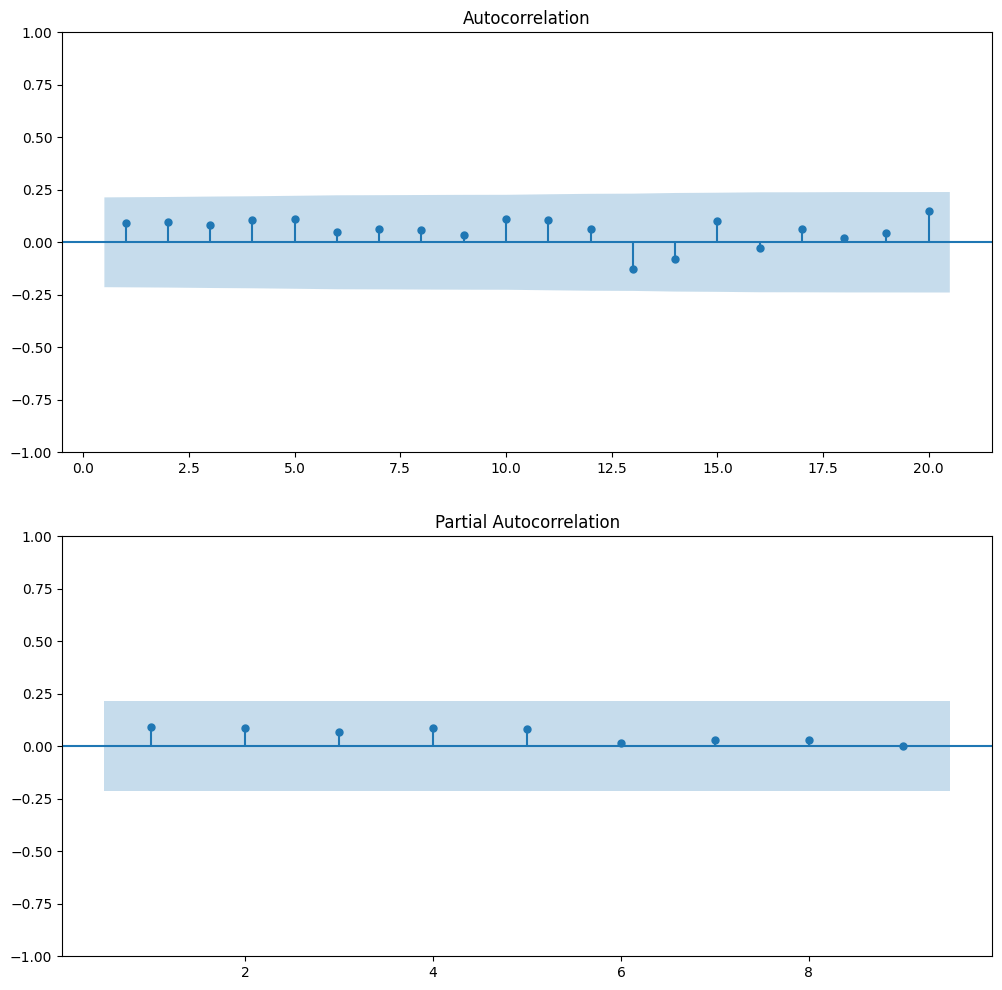

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.531293,0.768828


The above appears to be a good fit for our data (changed p from 3 to 4 which gave better AIC and BIC)

Residuals determined white noise


##Forecasting Error

In [ ]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,55.061487,-2118.512610,2228.635584
2004-03-01,97.068189,-2069.510054,2263.646432
2004-04-01,75.679555,-2089.529657,2240.888766
2004-05-01,104.079152,-2056.966007,2265.124312
2004-06-01,90.531547,-2070.036146,2251.099240


In [ ]:
# add back actuals --
prediction_df = pd.concat([prediction_df,united_cancelled_ts.to_frame(name='Cancelled')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()


,predicted_mean,lower_bound,upper_bound,Cancelled
Date,,,,
2004-02-01,55.061487,-2118.512610,2228.635584,312
2004-03-01,97.068189,-2069.510054,2263.646432,321
2004-04-01,75.679555,-2089.529657,2240.888766,162
2004-05-01,104.079152,-2056.966007,2265.124312,652
2004-06-01,90.531547,-2070.036146,2251.099240,549


In [ ]:
# calc error
errors = prediction_df['Cancelled'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Cancelled'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')

MAPE = 46.799%
RMSE = 366.922


In [ ]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,557.143934,-110.271480,1224.559348
2011-02-01,741.250614,65.726253,1416.774975
2011-03-01,444.022991,-270.319510,1158.365492
2011-04-01,179.661560,-541.501412,900.824532
2011-05-01,248.411520,-523.474916,1020.297956
2011-06-01,436.265682,-343.894796,1216.426160


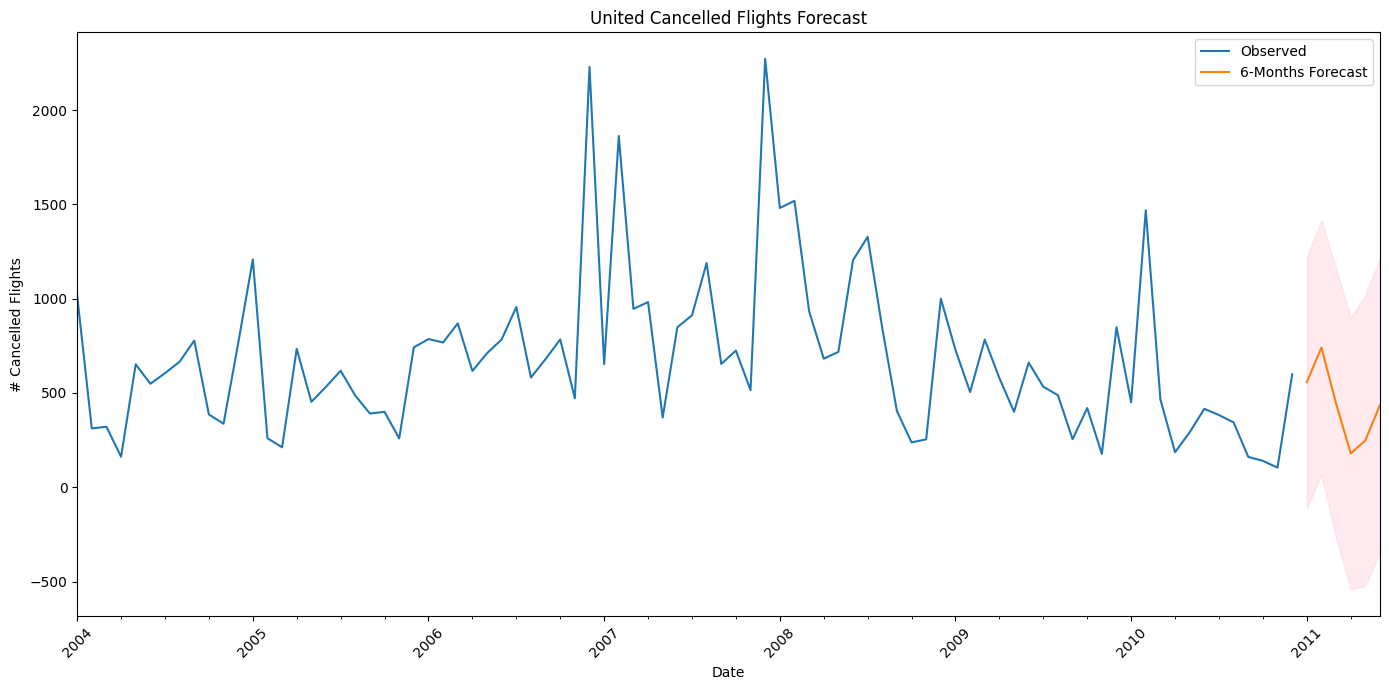

In [ ]:

# Plot forecast
plt.figure(figsize=(14, 7))
united_cancelled_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("United Cancelled Flights Forecast")
plt.xlabel("Date")
plt.ylabel("# Cancelled Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

##ARIMA FOR AMERICAN CANCELLED

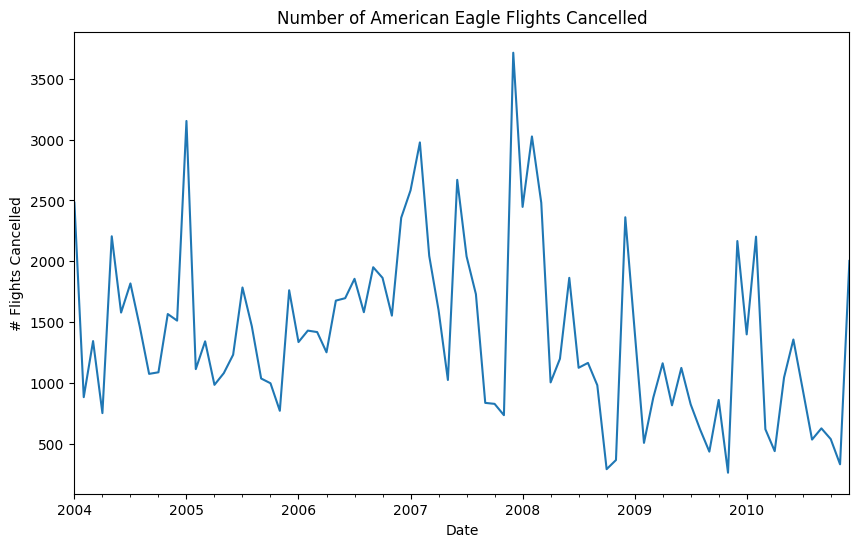

In [ ]:
# Create a monthly index for the series
american_cancelled_ts = pd.Series(american_eagle_df['Cancelled'].values, index=american_eagle_df['Date'])

american_cancelled_ts.index.freq = 'MS'


#Plot the series
plt.figure(figsize=(10, 6))
american_cancelled_ts.plot()
plt.title("Number of American Eagle Flights Cancelled")
plt.xlabel("Date")
plt.ylabel("# Flights Cancelled")
plt.show()

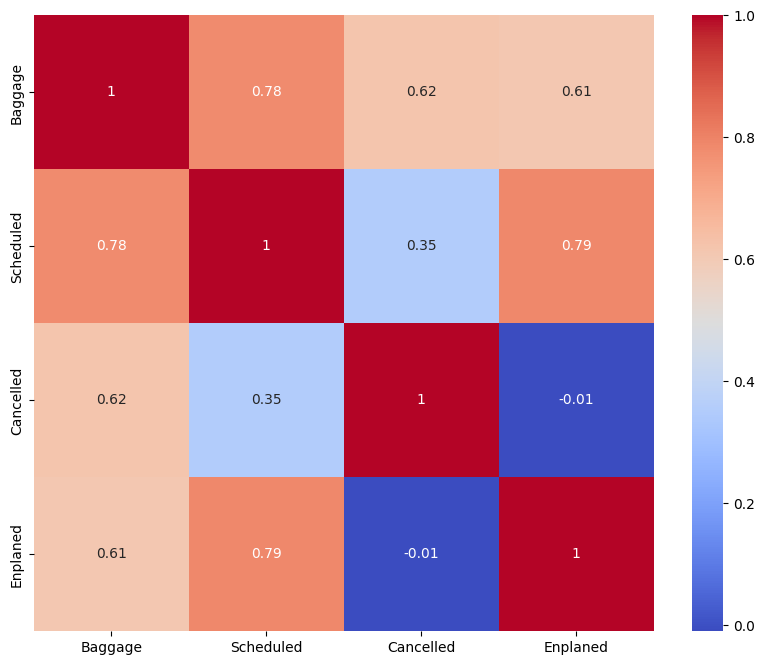

In [ ]:
#Produce Heat Map
american_dat_sub = american_eagle_df.drop(columns=['Airline', 'Date'])


# Compute correlations
cormat = american_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

In [ ]:
#Check for autocorrelation
American_Cancelled= american_eagle_df[['Cancelled']]
sm.stats.acorr_ljungbox(American_Cancelled, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,33.222572,0.00025


P-value < .05 so we conclude that autocorrelation is not white noise

##Plot ACF and PACF

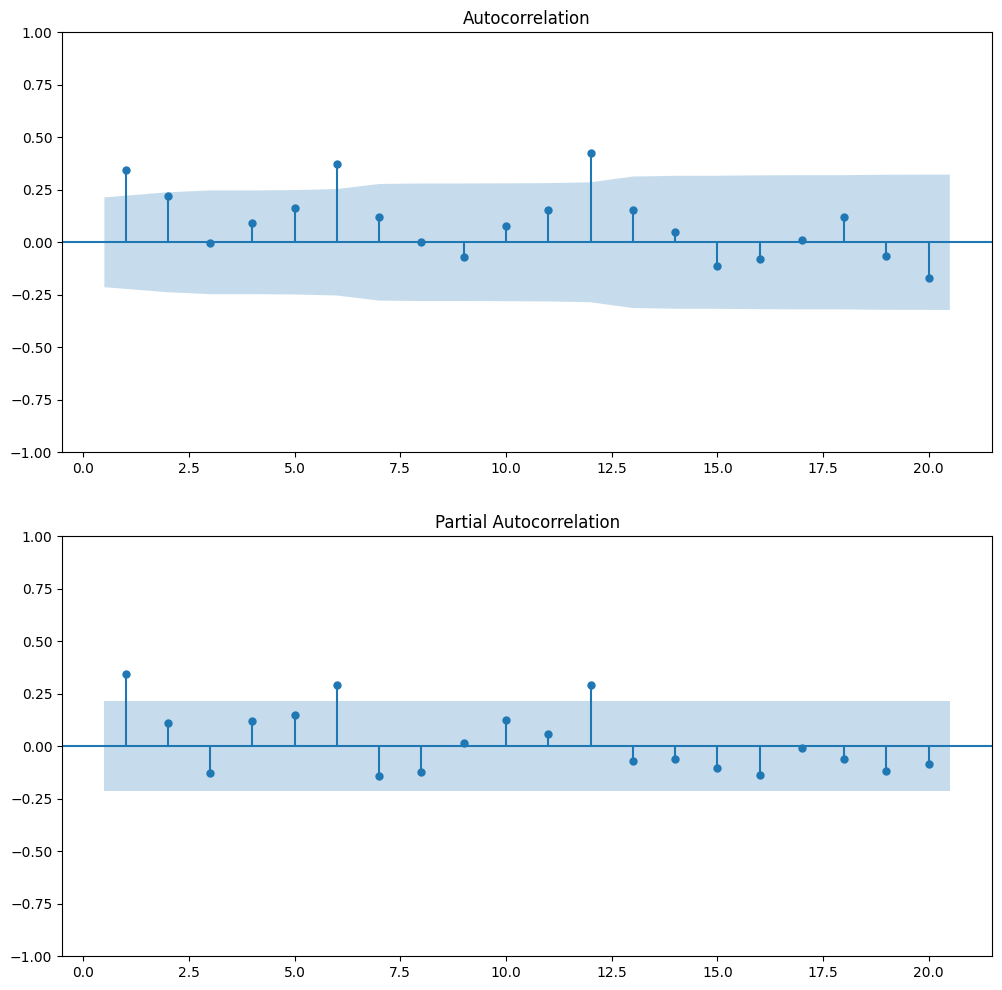

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(american_cancelled_ts, ax=ax1, zero=False)
plot_pacf(american_cancelled_ts, ax=ax2, zero=False)
plt.show()

##ARIMA Differencing

Seems to be spikes in ACF at around lag 6 and no other significant pattern in PACF; So choose S = 6, D = 1; Tried S=6, but S=12 fit better

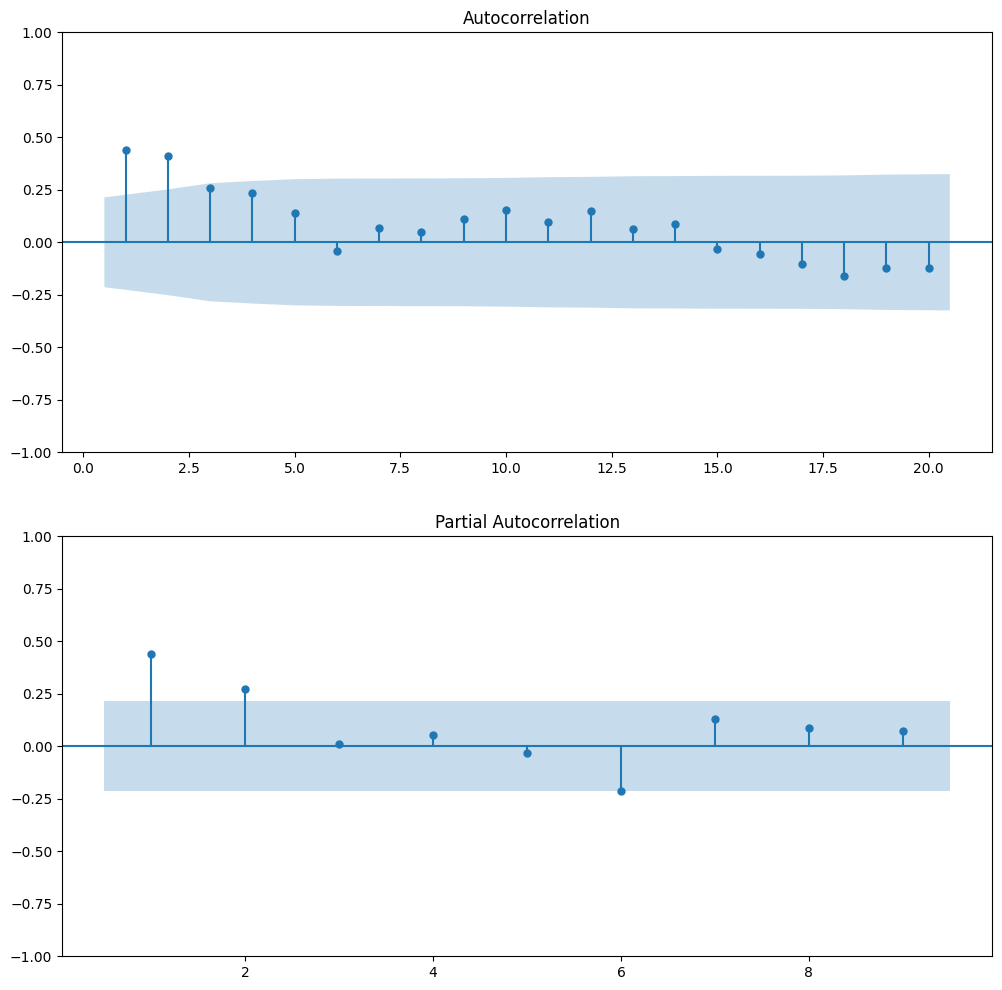

In [ ]:
# Fit ARIMA(0,0,0)x(0,1,1)[6] model to the data

amcan_fit_ARD12 = ARIMA(american_cancelled_ts, order=(0,0,0), seasonal_order=(0, 1, 1, 6)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

amcan_residuals12 = amcan_fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(amcan_residuals12, ax=ax1, zero=False)
plot_pacf(amcan_residuals12, ax=ax2, zero=False, lags=9)
plt.show()


                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                   84
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 6)   Log Likelihood                -608.743
Date:                         Tue, 24 Oct 2023   AIC                           1225.485
Time:                                 22:00:29   BIC                           1234.912
Sample:                             01-01-2004   HQIC                          1229.259
                                  - 12-01-2010                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7945      0.143      5.554      0.000       0.514       1.075
ma.L1         -0.4919      0.210     -2.348      0.019     

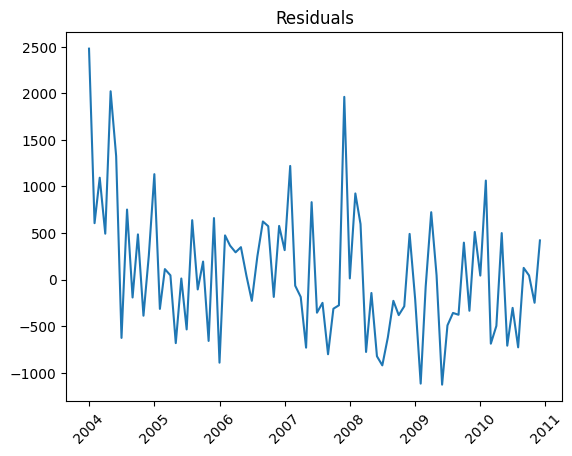

In [ ]:
#Best model for Cancelled Flights for American is ARIMA(1,0,1)x(0,1,1)[6] after many trial and errors
amcan_fit_AR1 = ARIMA(american_cancelled_ts, order=(1,0,1), seasonal_order=(0, 1, 1, 6)).fit()


# Summary of the ARIMA model
print(amcan_fit_AR1.summary())

# Examine residuals from the model
amcan_residuals = amcan_fit_AR1.resid
plt.plot(amcan_residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = amcan_fit_AR1.get_prediction()
print(pred_units)


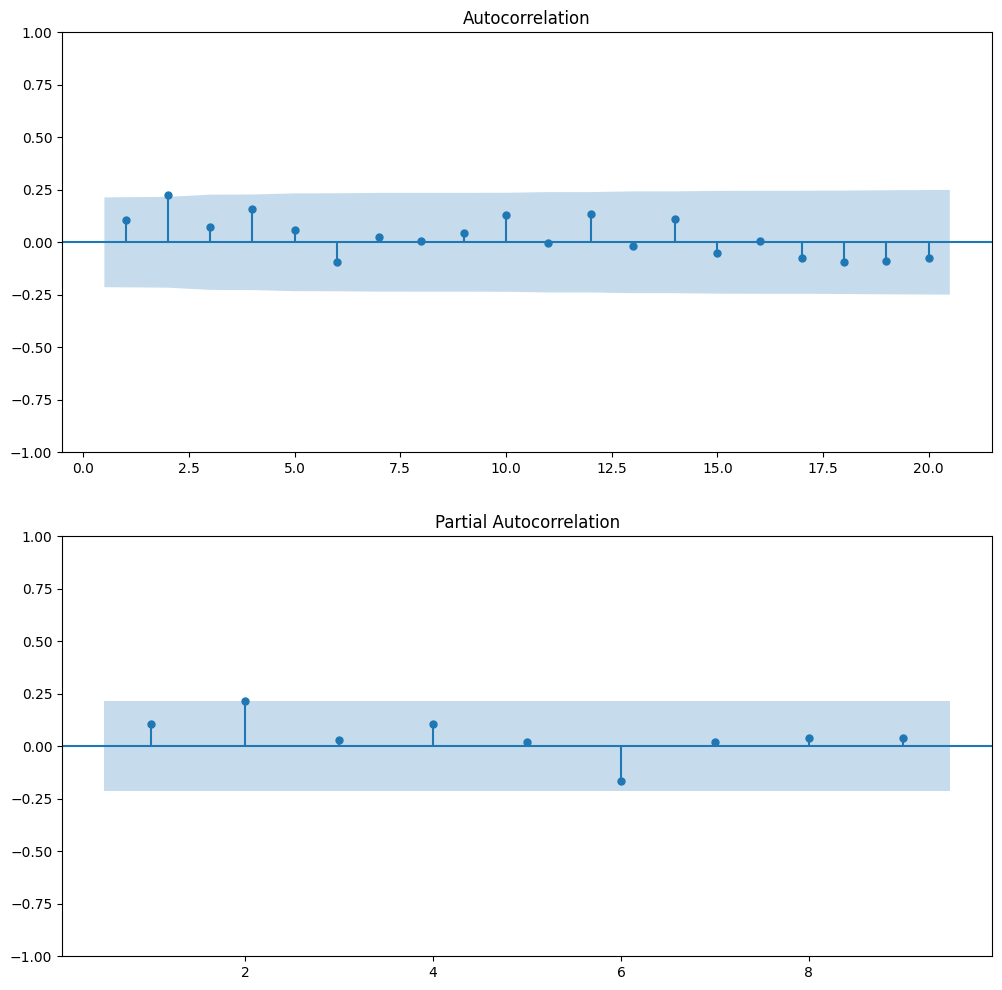

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(amcan_residuals, ax=ax1, zero=False)
plot_pacf(amcan_residuals, ax=ax2, zero=False, lags=9)
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(amcan_residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,11.263353,0.337372


In [ ]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,280.488336,-2149.946774,2710.923446
2004-03-01,251.896949,-2173.597511,2677.391410
2004-04-01,262.482200,-2162.087558,2687.051958
2004-05-01,182.921112,-2241.647740,2607.489963
2004-06-01,254.049276,-2169.737787,2677.836338


In [ ]:
# add back actuals --
prediction_df = pd.concat([prediction_df,american_cancelled_ts.to_frame(name='Cancelled')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,Cancelled
Date,,,,
2004-02-01,280.488336,-2149.946774,2710.923446,886
2004-03-01,251.896949,-2173.597511,2677.391410,1346
2004-04-01,262.482200,-2162.087558,2687.051958,755
2004-05-01,182.921112,-2241.647740,2607.489963,2206
2004-06-01,254.049276,-2169.737787,2677.836338,1580


In [ ]:
# calc error
errors = prediction_df['Cancelled'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Cancelled'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')

MAPE = 44.856%
RMSE = 647.379


In [ ]:
# Generate forecast for the next six months
forecast = amcan_fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,1224.355894,79.964617,2368.747170
2011-02-01,1160.112777,-35.503938,2355.729492
2011-03-01,786.724424,-440.123413,2013.572261
2011-04-01,678.976246,-567.180610,1925.133103
2011-05-01,633.106817,-625.084486,1891.298120
2011-06-01,1861.748302,596.020504,3127.476099


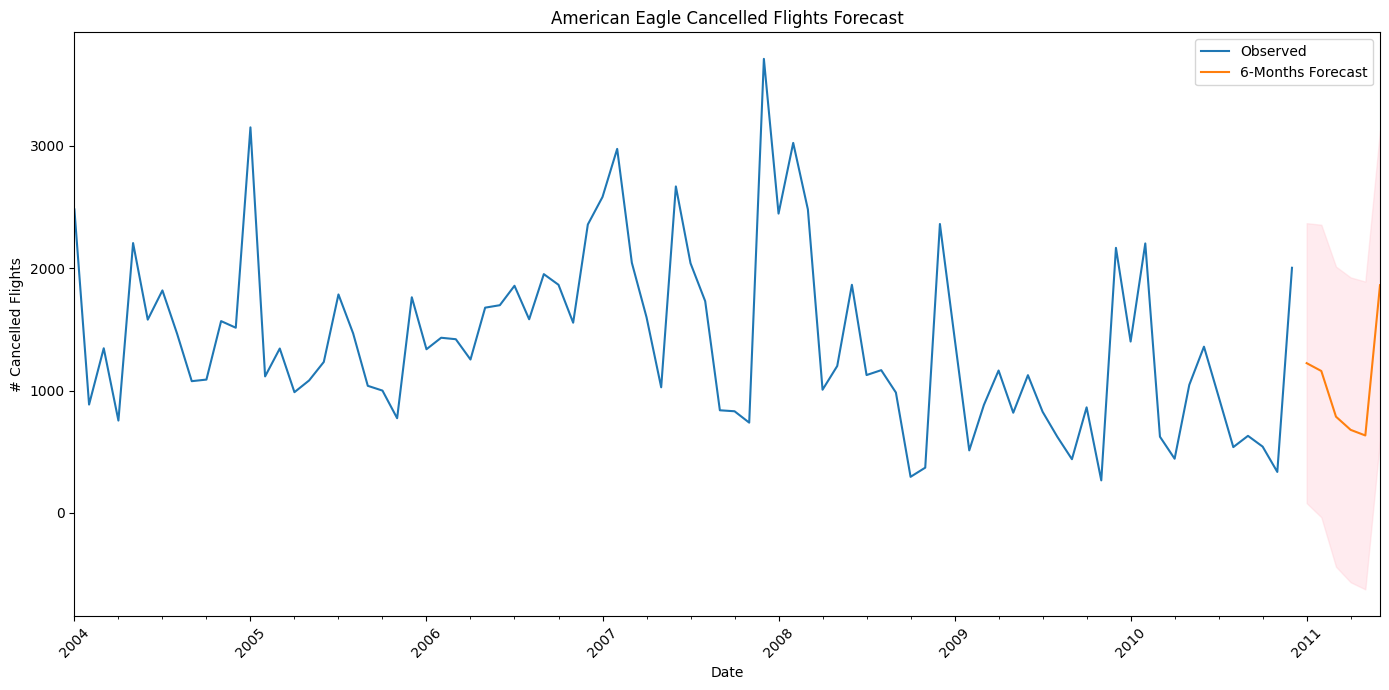

In [ ]:
# Plot forecast
plt.figure(figsize=(14, 7))
american_cancelled_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("American Eagle Cancelled Flights Forecast")
plt.xlabel("Date")
plt.ylabel("# Cancelled Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

#ARIMA American Baggage

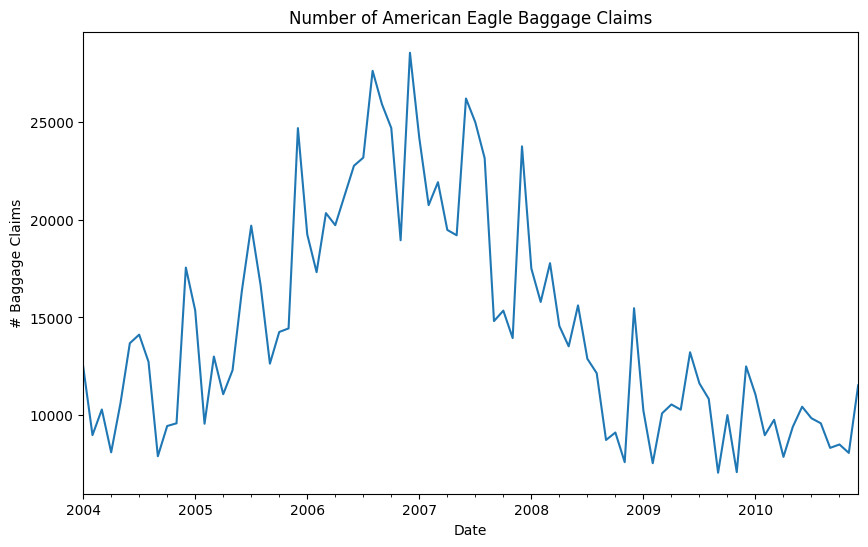

In [ ]:
# Create a monthly index for the series
american_bag_ts = pd.Series(american_eagle_df['Baggage'].values, index=american_eagle_df['Date'])

american_bag_ts.index.freq = 'MS'


#Plot the series
plt.figure(figsize=(10, 6))
american_bag_ts.plot()
plt.title("Number of American Eagle Baggage Claims")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.show()

In [ ]:
#Check for autocorrelation
American_Baggage= american_eagle_df[['Baggage']]
sm.stats.acorr_ljungbox(American_Baggage, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,363.970723,4.308185e-72


Conclude not white noise

##Plot ACF and PACF

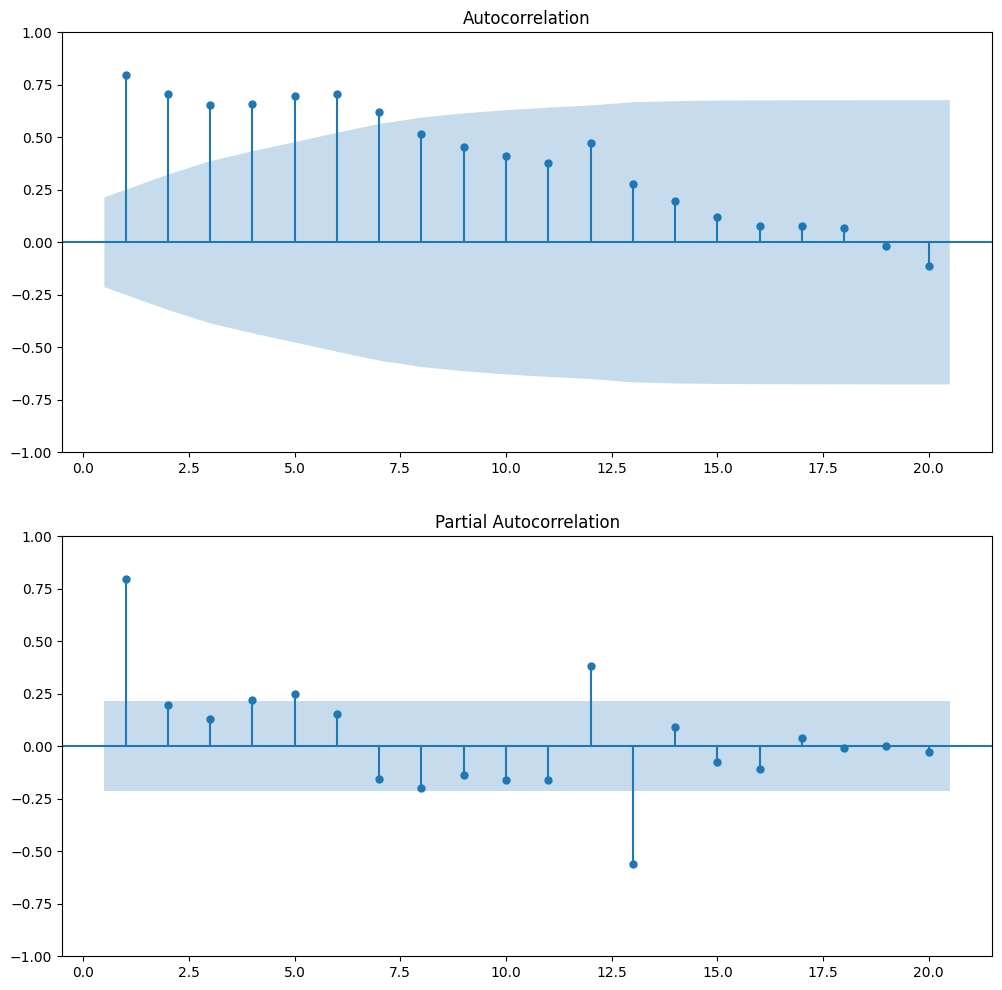

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(american_bag_ts, ax=ax1, zero=False)
plot_pacf(american_bag_ts, ax=ax2, zero=False)
plt.show()

##ARIMA Differencing

Choose S=12, D=1

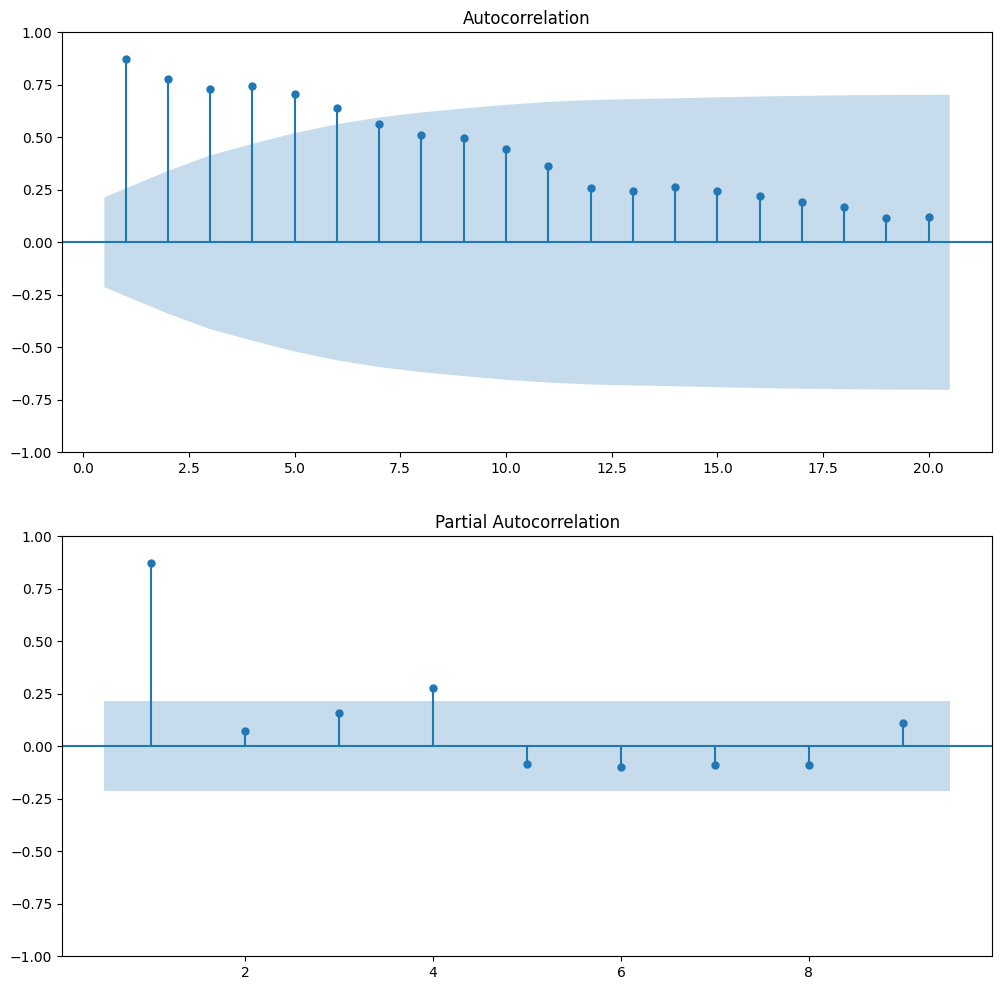

In [ ]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data

ambag_fit_ARD12 = ARIMA(american_bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

ambag_residuals12 = ambag_fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(ambag_residuals12, ax=ax1, zero=False)
plot_pacf(ambag_residuals12, ax=ax2, zero=False, lags=9)
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -667.070
Date:                            Tue, 24 Oct 2023   AIC                           1342.141
Time:                                    22:23:12   BIC                           1351.248
Sample:                                01-01-2004   HQIC                          1345.766
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7051      0.079      8.904      0.000       0.550       0.860
ar.L2          0.2444      0.089   

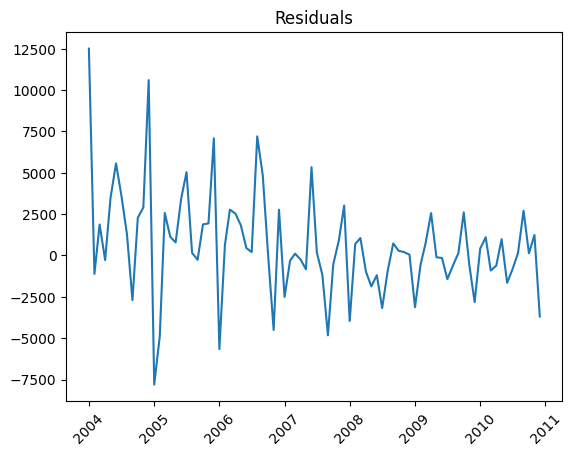

In [ ]:
# Fit ARIMA(2,0,0)x(0,1,1)[12] model to the data

#Best model for Baggage Complaints for American is ARIMA(2,0,0)x(0,1,1)[12] after many trial and error
ambag_fit_AR1 = ARIMA(american_bag_ts, order=(2,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(ambag_fit_AR1.summary())

# Examine residuals from the model
ambag_residuals = ambag_fit_AR1.resid
plt.plot(ambag_residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = ambag_fit_AR1.get_prediction()
print(pred_units)


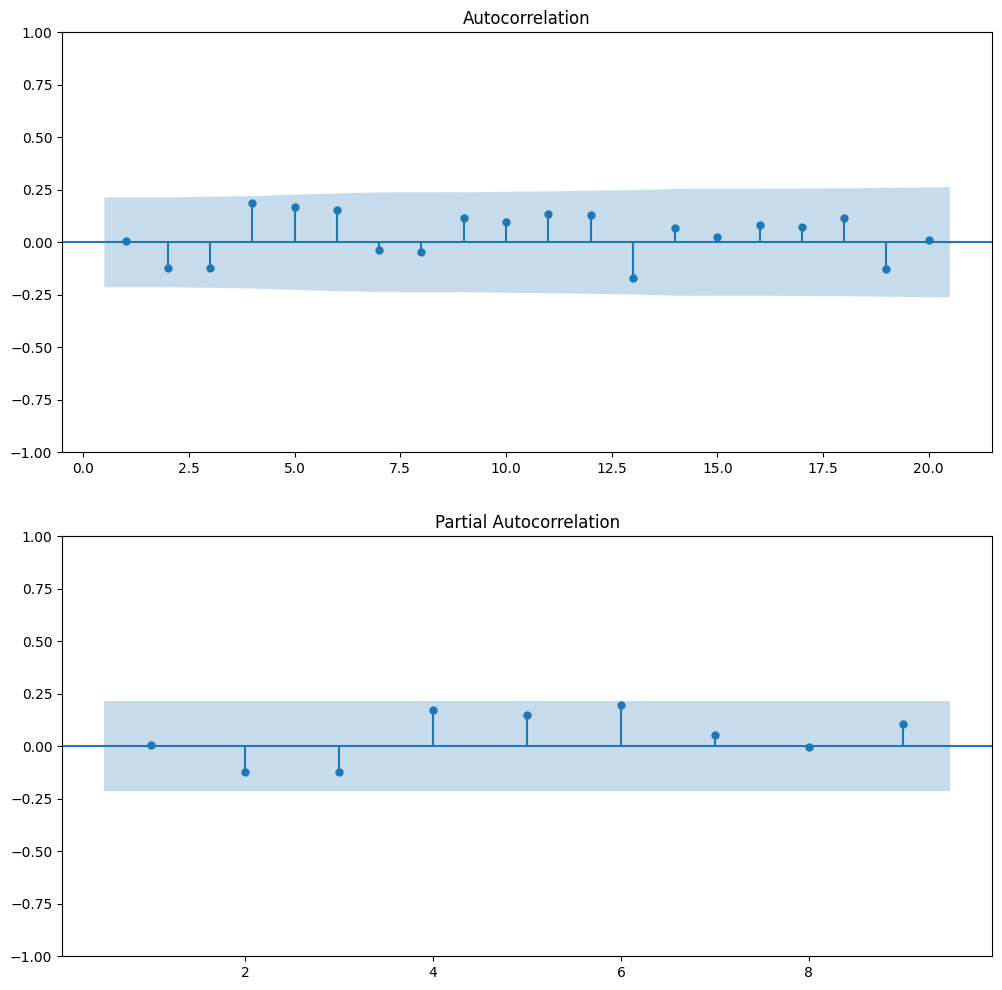

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(ambag_residuals, ax=ax1, zero=False)
plot_pacf(ambag_residuals, ax=ax2, zero=False, lags=9)
plt.show()

In [ ]:
sm.stats.acorr_ljungbox(ambag_residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,13.056615,0.220524


White Noise


##Forecasting

In [ ]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,10092.950094,3478.209676,16707.690513
2004-03-01,8420.857655,1973.217646,14868.497663
2004-04-01,8375.001878,1928.376351,14821.627405
2004-05-01,7156.667459,716.481718,13596.853199
2004-06-01,8122.384246,1691.849310,14552.919181


In [ ]:
# add back actuals --
prediction_df = pd.concat([prediction_df,american_bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
2004-02-01,10092.950094,3478.209676,16707.690513,8977
2004-03-01,8420.857655,1973.217646,14868.497663,10289
2004-04-01,8375.001878,1928.376351,14821.627405,8095
2004-05-01,7156.667459,716.481718,13596.853199,10618
2004-06-01,8122.384246,1691.849310,14552.919181,13684


In [ ]:
# calc error
errors = prediction_df['Baggage'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Baggage'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')

MAPE = 14.356%
RMSE = 2,918.943


In [ ]:
# Generate forecast for the next six months
forecast = ambag_fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_CPI': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_CPI,Lower_Bound,Upper_Bound
2011-01-01,10275.679149,5705.106014,14846.252284
2011-02-01,7238.581820,1664.384365,12812.779274
2011-03-01,9149.131877,2648.226661,15650.037092
2011-04-01,7554.071789,341.061745,14767.081832
2011-05-01,8178.671769,363.544783,15993.798755
2011-06-01,10939.676467,2613.910579,19265.442355


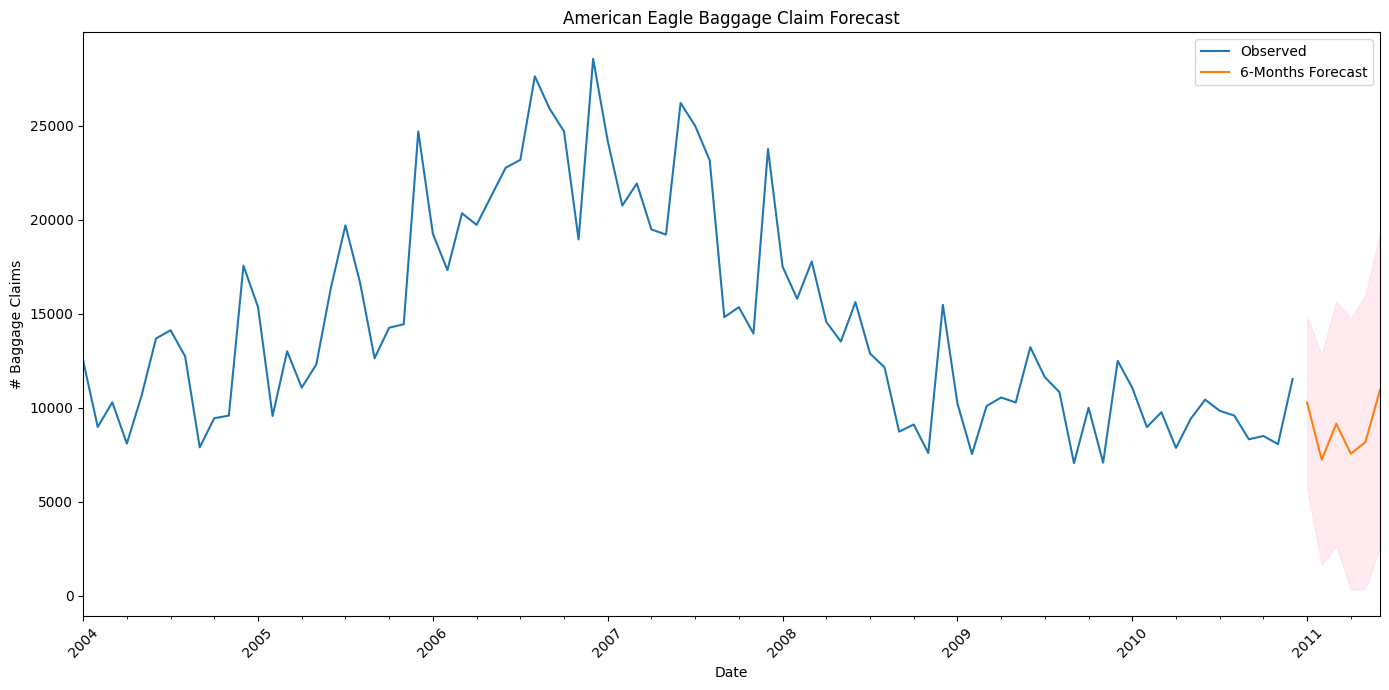

In [ ]:
# Plot forecast
plt.figure(figsize=(14, 7))
american_bag_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("American Eagle Baggage Claim Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/Project2_Forecasting_Kaitlyn_Vickers.ipynb

[NbConvertApp] Converting notebook /content/Project2_Forecasting_Kaitlyn_Vickers.ipynb to html
[NbConvertApp] Writing 2133954 bytes to /content/Project2_Forecasting_Kaitlyn_Vickers.html
